In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time

import matplotlib.pyplot as plt

from pyspark.sql import *
from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as sk_DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as sk_LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
import findspark
findspark.init("C:\\Spark\\spark-3.1.1-bin-hadoop2.7")

In [3]:
findspark.find()

'C:\\Spark\\spark-3.1.1-bin-hadoop2.7'

In [4]:
#spark_home = os.environ.get('SPARK_HOME', None)
#if not spark_home:
    #raise ValueError('SPARK_HOME environment variable is not set')
    
#sys.path.insert(0, os.path.join(spark_home, 'python'))
#sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))
#exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

In [5]:
spark = SparkSession.builder.master("local").appName('abc').getOrCreate()

In [6]:
insurance = pd.read_csv('insurance_1.csv',engine='python', delimiter=',')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [7]:
insurance.isnull().values.any()

False

In [8]:
#insurance['Date'] = pd.to_datetime(insurance['Date']).astype(np.int64)
#insurance['Date']
#insurance.drop()
#insurance['date'] = pd.to_datetime(insurance['date'])
#insurance['date']

insurance['smoker'] = insurance['smoker'].replace({'yes': True, 'no': False})
insurance['sex'] = insurance['sex'].replace({'male': True, 'female': False})
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,False,27.900,0,True,southwest,16884.92400
1,18,True,33.770,1,False,southeast,1725.55230
2,28,True,33.000,3,False,southeast,4449.46200
3,33,True,22.705,0,False,northwest,21984.47061
4,32,True,28.880,0,False,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,True,30.970,3,False,northwest,10600.54830
1334,18,False,31.920,0,False,northeast,2205.98080
1335,18,False,36.850,0,False,southeast,1629.83350
1336,21,False,25.800,0,False,southwest,2007.94500


In [9]:
insurance=pd.get_dummies(insurance)
insurance = insurance.apply(pd.to_numeric)
insurance

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,False,27.900,0,True,16884.92400,0,0,0,1
1,18,True,33.770,1,False,1725.55230,0,0,1,0
2,28,True,33.000,3,False,4449.46200,0,0,1,0
3,33,True,22.705,0,False,21984.47061,0,1,0,0
4,32,True,28.880,0,False,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,True,30.970,3,False,10600.54830,0,1,0,0
1334,18,False,31.920,0,False,2205.98080,1,0,0,0
1335,18,False,36.850,0,False,1629.83350,0,0,1,0
1336,21,False,25.800,0,False,2007.94500,0,0,0,1


In [10]:
insurance = spark.createDataFrame(insurance)

In [11]:
insurance

DataFrame[age: bigint, sex: boolean, bmi: double, children: bigint, smoker: boolean, charges: double, region_northeast: bigint, region_northwest: bigint, region_southeast: bigint, region_southwest: bigint]

In [12]:
insurance.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: boolean (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: long (nullable = true)
 |-- smoker: boolean (nullable = true)
 |-- charges: double (nullable = true)
 |-- region_northeast: long (nullable = true)
 |-- region_northwest: long (nullable = true)
 |-- region_southeast: long (nullable = true)
 |-- region_southwest: long (nullable = true)



In [13]:
insurance.show()

+---+-----+------+--------+------+------------------+----------------+----------------+----------------+----------------+
|age|  sex|   bmi|children|smoker|           charges|region_northeast|region_northwest|region_southeast|region_southwest|
+---+-----+------+--------+------+------------------+----------------+----------------+----------------+----------------+
| 19|false|  27.9|       0|  true|         16884.924|               0|               0|               0|               1|
| 18| true| 33.77|       1| false|         1725.5523|               0|               0|               1|               0|
| 28| true|  33.0|       3| false|          4449.462|               0|               0|               1|               0|
| 33| true|22.705|       0| false|       21984.47061|               0|               1|               0|               0|
| 32| true| 28.88|       0| false|         3866.8552|               0|               1|               0|               0|
| 31|false| 25.74|      

In [14]:
features = insurance.drop('charges')
assembler = VectorAssembler(inputCols=features.columns, outputCol='features')
output = assembler.transform(insurance).select('features','charges')

In [15]:
train, test = output.randomSplit([0.75, 0.25], seed=47)
train.show()

+--------------------+----------+
|            features|   charges|
+--------------------+----------+
|(9,[0,1,2,5],[18....| 1694.7964|
|(9,[0,1,2,5],[18....| 1702.4553|
|(9,[0,1,2,5],[18....|1704.70015|
|(9,[0,1,2,5],[18....| 1705.6245|
|(9,[0,1,2,5],[18....|1708.92575|
|(9,[0,1,2,5],[20....| 1967.0227|
|(9,[0,1,2,5],[20....| 1984.4533|
|(9,[0,1,2,5],[22....| 2250.8352|
|(9,[0,1,2,5],[22....| 2254.7967|
|(9,[0,1,2,5],[23....| 2396.0959|
|(9,[0,1,2,5],[25....| 2727.3951|
|(9,[0,1,2,5],[26....| 2897.3235|
|(9,[0,1,2,5],[27....| 3070.8087|
|(9,[0,1,2,5],[28....|3268.84665|
|(9,[0,1,2,5],[30....| 3645.0894|
|(9,[0,1,2,5],[31....|3857.75925|
|(9,[0,1,2,5],[33....|12404.8791|
|(9,[0,1,2,5],[34....|4500.33925|
|(9,[0,1,2,5],[34....|4518.82625|
|(9,[0,1,2,5],[43....| 6837.3687|
+--------------------+----------+
only showing top 20 rows



In [16]:
#SparkSession.stop(spark)

In [17]:
#insurance.limit(10).toPandas()

In [18]:
features.columns

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [19]:
lr = LinearRegression(featuresCol = 'features', labelCol='charges', maxIter=10, regParam=0.3, elasticNetParam=0.8)

start = time.time()
lr_model = lr.fit(train)
print('fit:', time.time() - start)

start = time.time()
prediction = lr_model.transform(test)
print('pred:', time.time() - start)

fit: 1.7345759868621826
pred: 0.01601433753967285


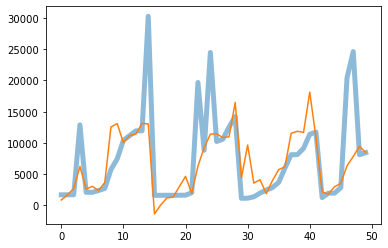

In [20]:
plt.plot(range(50),  prediction.toPandas()['charges'][:50], linewidth=5, alpha=0.5)
plt.plot(range(50), prediction.toPandas()['prediction'][:50])

In [21]:
pred_eval = RegressionEvaluator(predictionCol='prediction', labelCol = 'charges', metricName='mse')
pred_eval.evaluate(prediction)

36427107.4017943

In [22]:
pred_eval = RegressionEvaluator(predictionCol='prediction', labelCol = 'charges', metricName='r2')
pred_eval.evaluate(prediction)

0.7639791067725314

# sklearn linreg

In [23]:
sk_insurance = insurance.toPandas()
X_train, X_test, y_train, y_test = train_test_split(sk_insurance.drop('charges', axis=1), sk_insurance['charges'], test_size=0.25, random_state=47)

In [24]:
start = time.time()
sk_reg = sk_LinearRegression().fit(X_train, y_train)
print('fit:', time.time() - start)

start = time.time()
y_res = sk_reg.predict(X_test)
print('pred:', time.time() - start)

fit: 0.1881706714630127
pred: 0.0020020008087158203


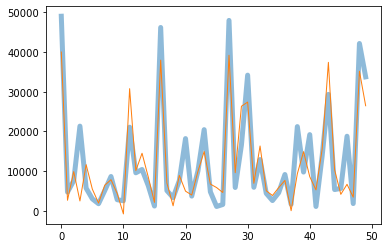

In [25]:
plt.plot(range(50), y_test[:50], linewidth=5, alpha=0.5)
plt.plot(range(50), y_res[:50], linewidth=1)

In [26]:
print(mean_squared_error(y_test,y_res))
print(sk_reg.score(X_test, y_test))


34120930.701114096
0.7784450657210209


# spark dectree

In [27]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol = 'charges', maxDepth=6, seed=47)

start = time.time()
dt_model = dt.fit(train)
print('fit:', time.time() - start)

start = time.time()
prediction = dt_model.transform(test)
print('pred:', time.time() - start)

fit: 2.383165121078491
pred: 0.02402210235595703


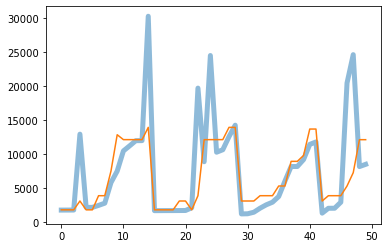

In [28]:
plt.plot(range(50),  prediction.toPandas()['charges'][:50], linewidth=5, alpha=0.5)
plt.plot(range(50), prediction.toPandas()['prediction'][:50])

In [29]:
pred_eval = RegressionEvaluator(predictionCol='prediction', labelCol = 'charges', metricName='mse')
pred_eval.evaluate(prediction)

24256825.80961724

In [30]:
pred_eval = RegressionEvaluator(predictionCol='prediction', labelCol = 'charges', metricName='r2')
pred_eval.evaluate(prediction)

0.8428335900707018

In [31]:
insurance.toPandas()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,False,27.900,0,True,16884.92400,0,0,0,1
1,18,True,33.770,1,False,1725.55230,0,0,1,0
2,28,True,33.000,3,False,4449.46200,0,0,1,0
3,33,True,22.705,0,False,21984.47061,0,1,0,0
4,32,True,28.880,0,False,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,True,30.970,3,False,10600.54830,0,1,0,0
1334,18,False,31.920,0,False,2205.98080,1,0,0,0
1335,18,False,36.850,0,False,1629.83350,0,0,1,0
1336,21,False,25.800,0,False,2007.94500,0,0,0,1


# sklearn dectree

fit: 0.011009454727172852
pred: 0.002002716064453125


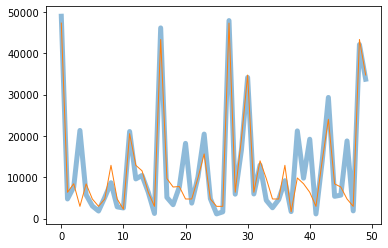

In [32]:
sk_dt = sk_DecisionTreeRegressor(max_depth=6,  random_state=47)

start = time.time()
sk_dt.fit(X_train, y_train)
print('fit:', time.time() - start)

start = time.time()
y_res = sk_dt.predict(X_test)
print('pred:', time.time() - start)

plt.plot(range(50), y_test[:50], linewidth=5, alpha=0.5)
plt.plot(range(50), y_res[:50], linewidth=1)

In [33]:
print(mean_squared_error(y_test,y_res))
print(sk_dt.score(X_test, y_test))


25064922.03119789
0.837247781956063
